In [1]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot
import matplotlib.pyplot as plt

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import median_abs_deviation
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing

# from collections import Counter
# from sklearn.datasets import make_classification
# from sklearn.cluster import MiniBatchKMeans
# from imblearn.under_sampling import ClusterCentroids
# from sklearn.cluster import (
#     KMeans,
#     MiniBatchKMeans,
#     AgglomerativeClustering,
#     DBSCAN,
#     MeanShift,
#     estimate_bandwidth,
# )


In [22]:

def plt_boxplot(df_toplt, plt_name="1"):
    figsize = (len(df_toplt.columns), len(df_toplt.columns)+10)

    # Listing numeric columns
    v_n = list(df_toplt.select_dtypes(include=["float64", "int64"]).columns)
    # Plot
    plt.figure(figsize=figsize)
    x = 1
    for column in v_n:
        plt.subplot(((df_toplt.shape[1] // 3) + 1), 3, x)
        sns.boxplot(df_toplt[column])
        plt.title(
            "BoxPlot {}".format(column), fontsize=12, color="dimgrey", fontweight="bold"
        )
        x += 1

def plt_dist(df_toplt, plt_name="1"):
    figsize = (len(df_toplt.columns), len(df_toplt.columns) +15)

    v_n = list(df_toplt.select_dtypes(include=["float64", "int64"]).columns)
    plt.figure(figsize=figsize)
    x = 1
    for column in v_n:
        plt.subplot(((df_toplt.shape[1] // 3) + 1), 3, x)
        sns.distplot(df_toplt[column])
        plt.title(
            "Distribution {}".format(column),
            fontsize=10,
            color="dimgrey",
            fontweight="bold",
            y=1,
        )
        x += 1
    

def plt_histo(df_toplt, plt_name="1"):
    figsize = (len(df_toplt.columns)+5, len(df_toplt.columns) +15)

    v_n = list(df_toplt.select_dtypes(include=["float64", "int64"]).columns)
    plt.figure(figsize=figsize)
    x = 1
    for column in v_n:
        plt.subplot(((df_toplt.shape[1] // 3) + 1), 3, x)
        plt.hist(df_toplt[column], bins=120, linewidth=0.5, edgecolor="white")
        plt.title(
            "Distribution {}".format(column),
            fontsize=10,
            color="dimgrey",
            fontweight="bold",
            y=1,
        )
        x += 1

In [24]:
df = pd.read_pickle("mqi_data_aggregated/aggreg_df.pkl")

# mq_df_features = list(df.select_dtypes(include=["float64", "int64"]).columns)
# mq_df = mq_df.loc[~(mq_df["model_score_avg"].isna())]

In [25]:

print(df.shape)
# remove null model scores and #remove Model scores that are 0, note this will remove fixed limits (model score 0)
df = df.loc[~(df["modeltype"] == 'Fixed Limit')]
print(df.shape)

# remove null model scores and #remove Model scores that are 0, note this will remove fixed limits (model score 0)
df = df.loc[~(df["model_score_avg"].isna())]
print(df.shape)

df = df.loc[~(df["actual_vs_expected_percdiff"].isna())]
print(df.shape)

#remove any rows that have no actual, upper, or lower values for model values
df = df.loc[~((df['actual_vs_expected_percdiff']==0) & (df['upper_vs_actual_percdiff']==0) & (df['lower_vs_actual_percdiff']==0))]
print(df.shape)

#remove any rows that have no actual, upper, or lower values for model values
df = df.loc[(df['actual_vs_expected_percdiff']<200) & (df['upper_vs_actual_percdiff']<200) & (df['lower_vs_actual_percdiff']<200)]
print(df.shape)

df = df.loc[df['model_age'] > 4]

print(df.shape)
# drop any columns with all zero values after removing rows
for col in df.columns:
    if df[col].sum() == 0:
        df.drop(columns=col, inplace=True)
        print(f"dropped: {col}")


mq_df_features = list(df.select_dtypes(include=["float64", "int64"]).columns)

(22101, 37)
(19558, 37)
(18952, 37)
(18379, 37)
(18364, 37)
(16176, 37)
(15905, 37)


In [10]:
df.isna().sum()

modeltype                                    0
site                                         0
currently_active_False                       0
currently_active_True                        0
model_save_freq                              0
model_build_freq                             0
model_score_avg                              0
position_class_group                         0
HHA_freq                                     0
noAlert_freq                                 0
AAF_freq                                     0
WOR_freq                                     0
FRQ_freq                                     0
AAS_freq                                     0
OSC_freq                                     0
LLA_freq                                     0
model_age                                    0
actual_vs_expected_percdiff                  0
upper_vs_actual_percdiff                     0
lower_vs_actual_percdiff                     0
case_count_freq                              0
action_note_l

In [14]:
dfcpy = df[mq_df_features].copy()

columns_to_norm = [
    col for col in dfcpy.columns if len(dfcpy[col].value_counts()) != 2
]

dfcpy[columns_to_norm] = dfcpy[columns_to_norm].apply(lambda x: np.log(x + 1))

df = dfcpy

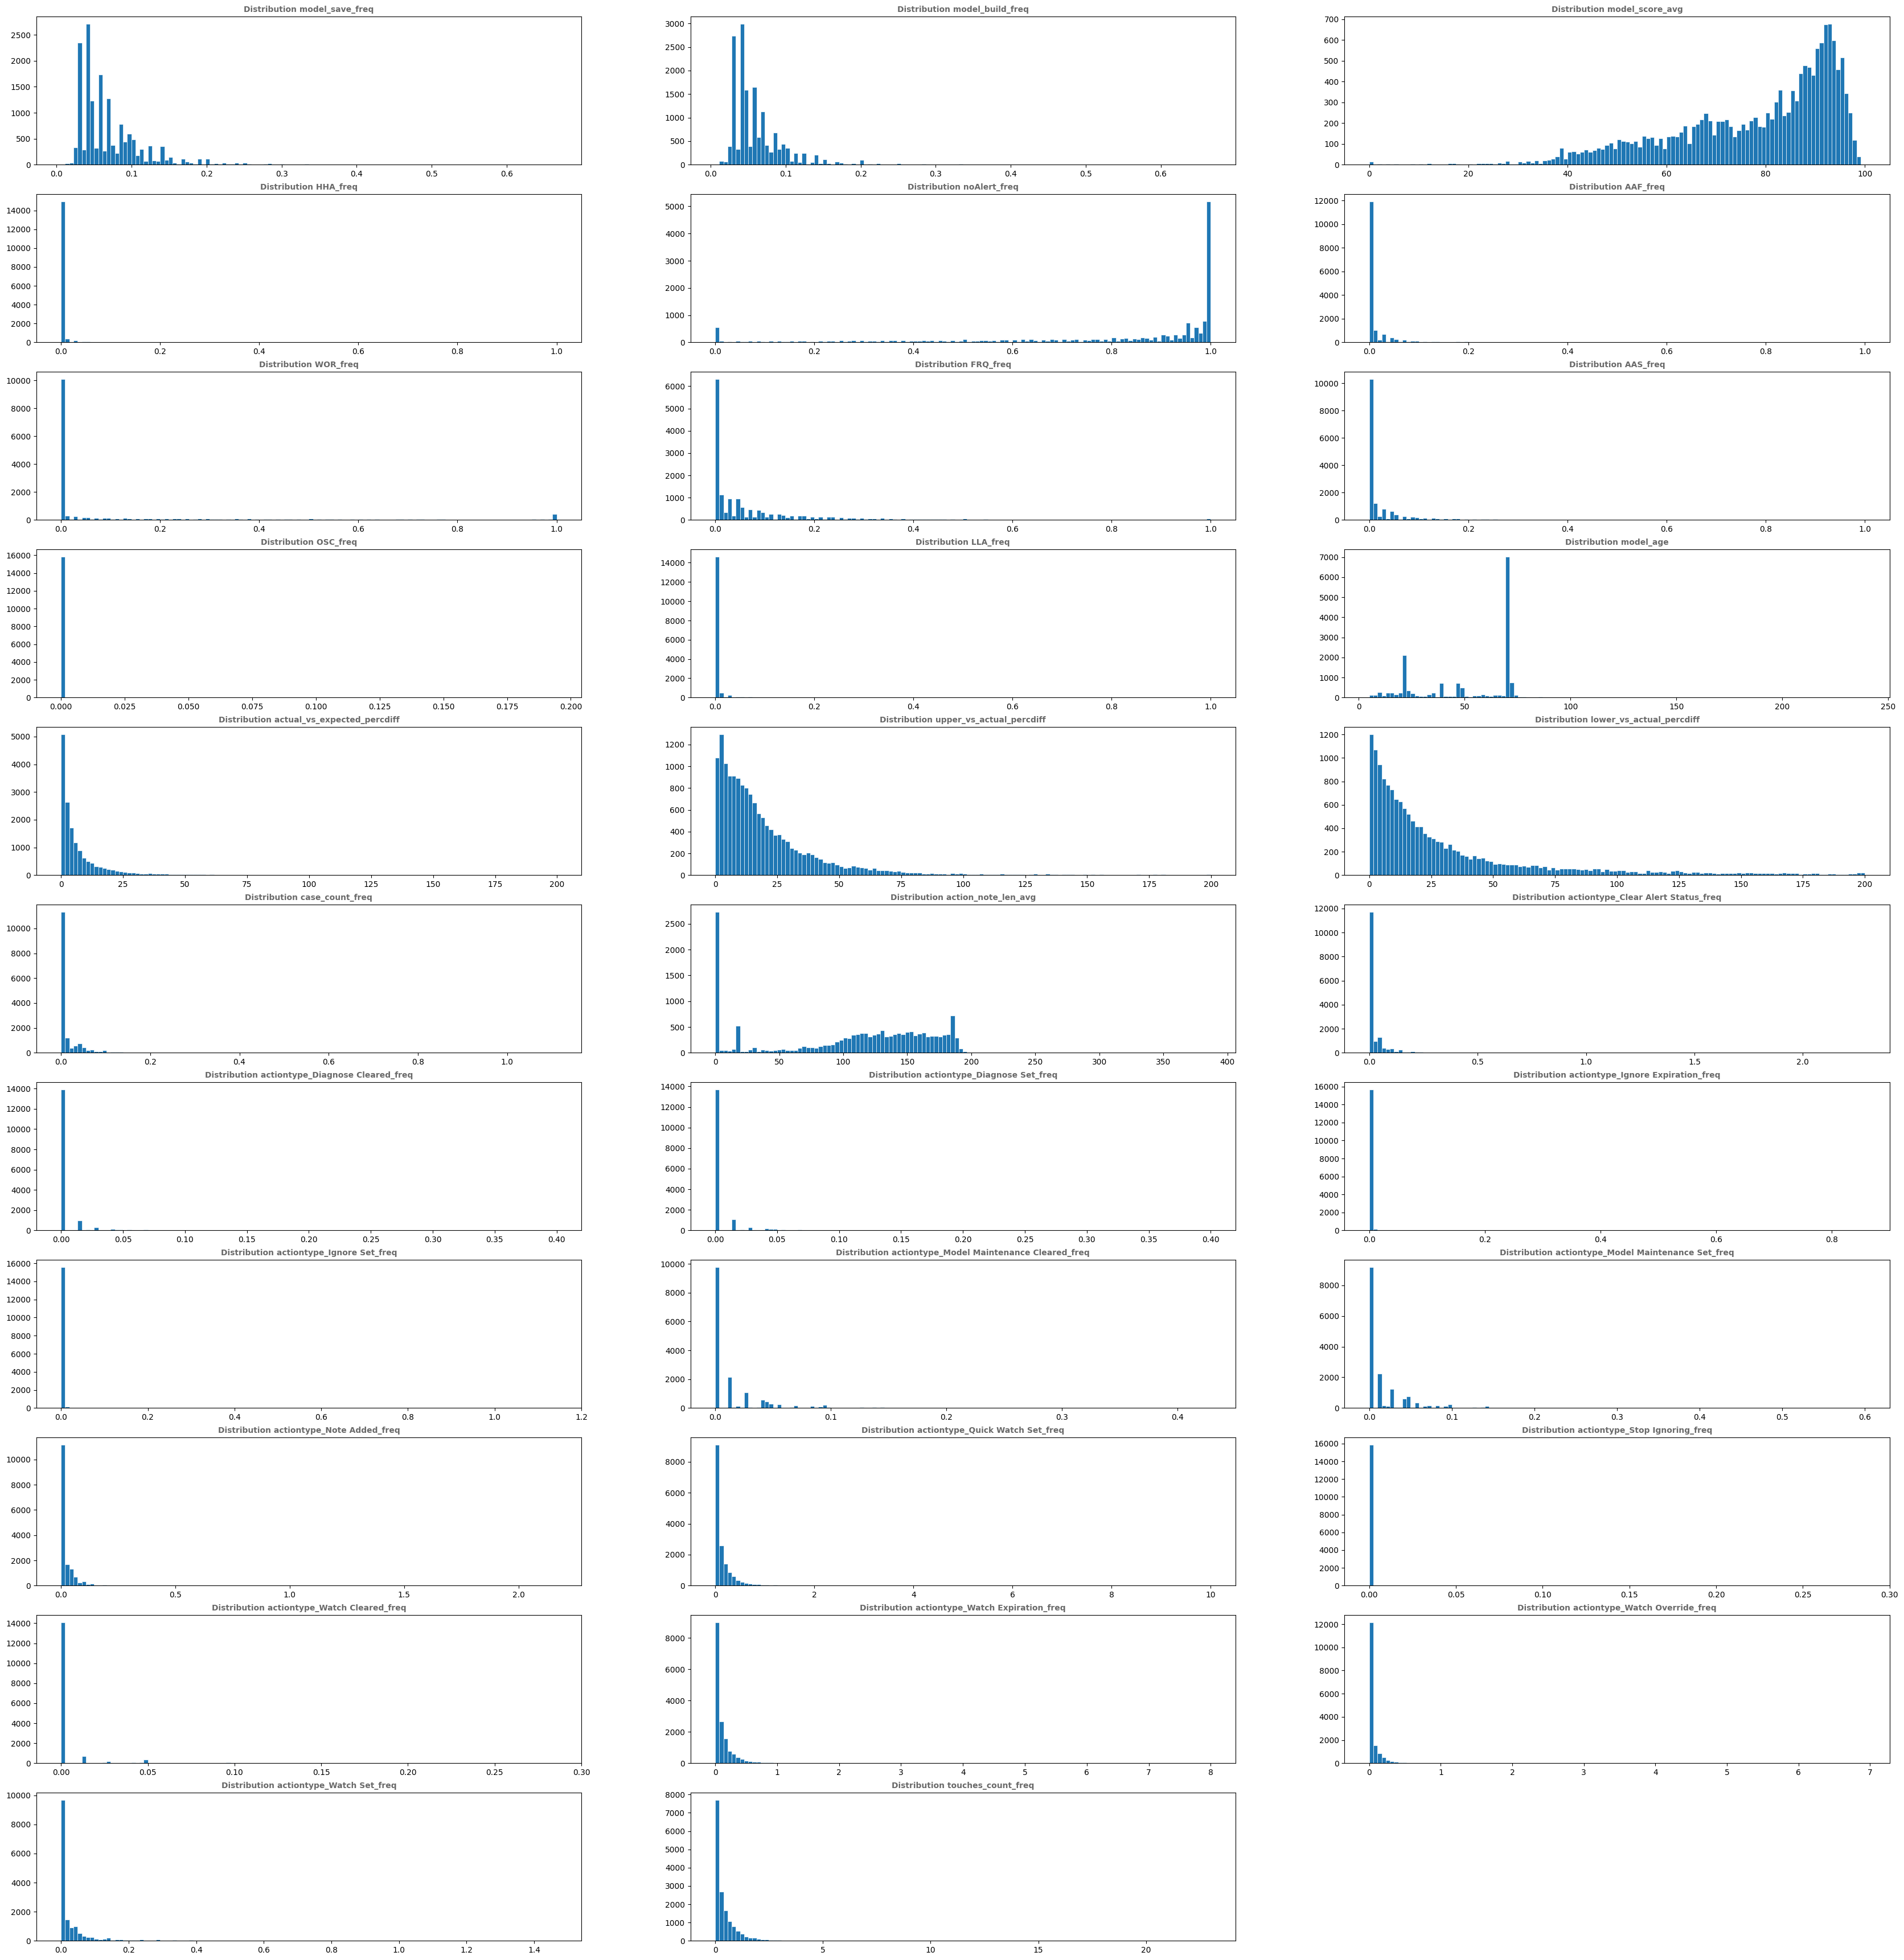

In [26]:
plt_histo(df)

Total number of outliers is: 1104


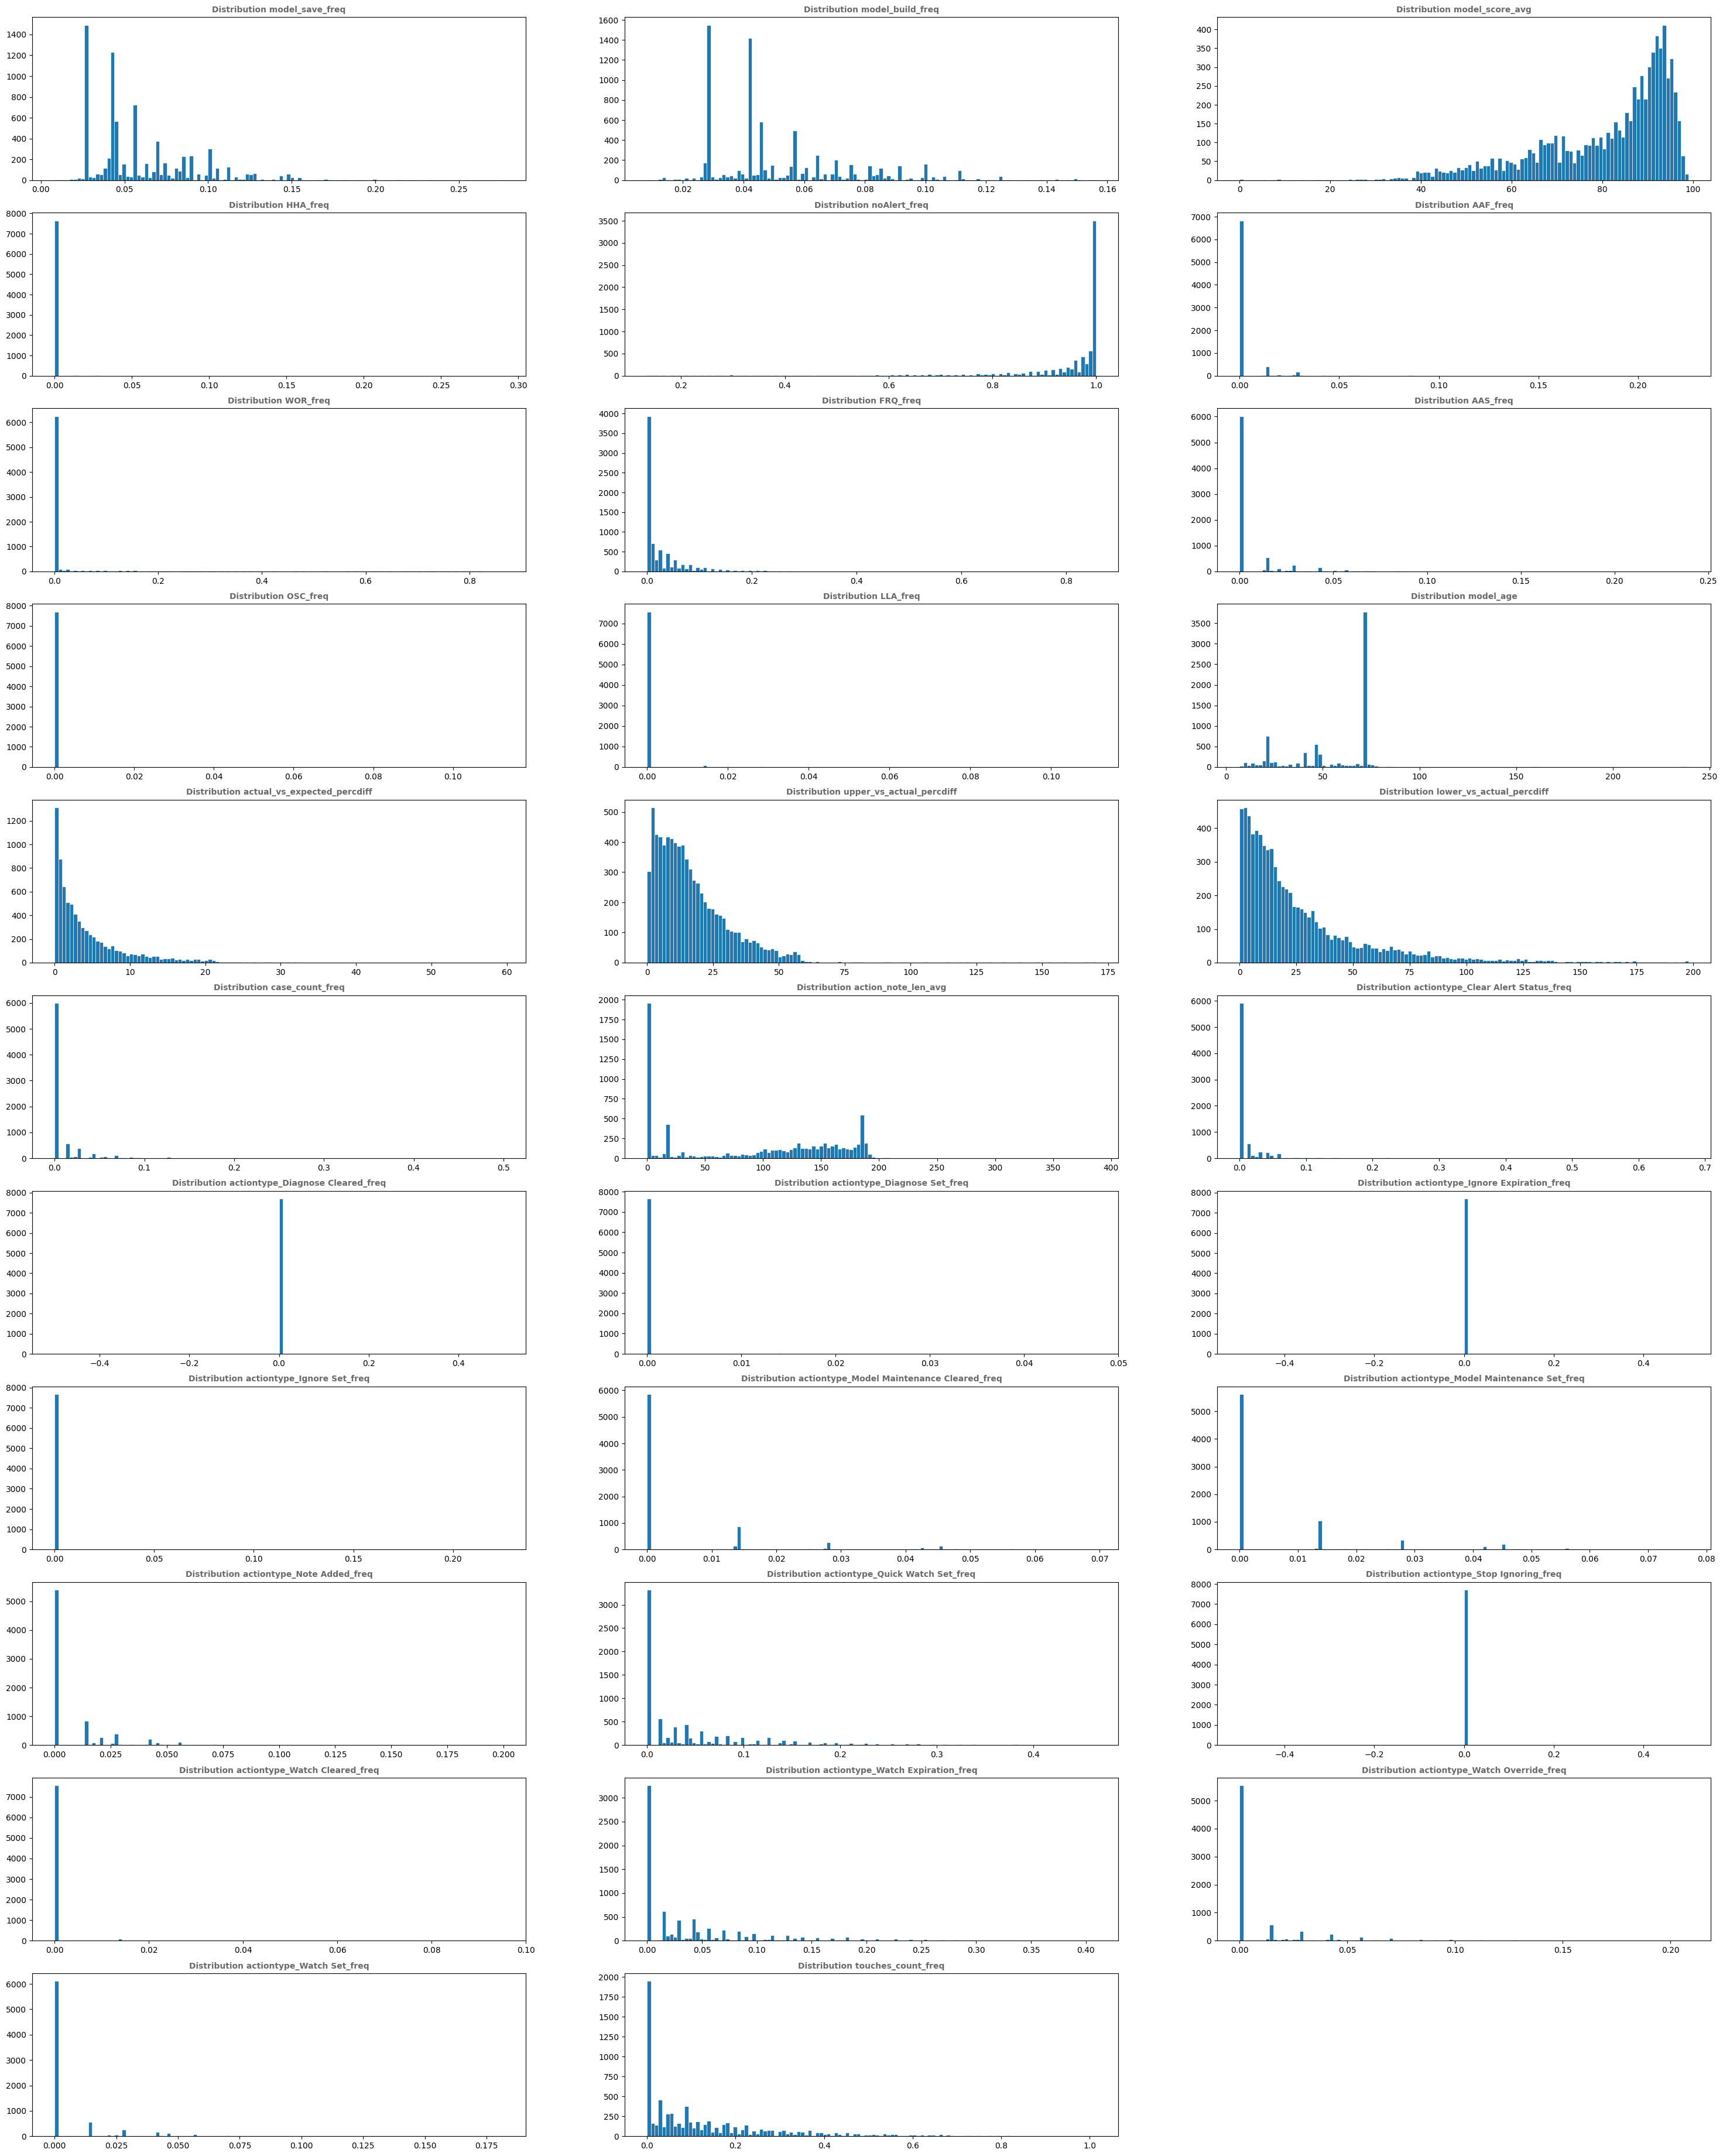

In [27]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

# # detecting outliers
# Outliers_iqr_cc = IQR_method(cc_df,1,cc_df_features)
# # dropping outliers
# cc_df_iqr = cc_df.drop(Outliers_iqr_cc, axis = 0).reset_index(drop=True)


# detecting outliers
Outliers_iqr_mq = IQR_method(df,1,mq_df_features)
# dropping outliers
mq_df_iqr = df.drop(Outliers_iqr_mq, axis = 0).reset_index(drop=True)


# plt_histo(cc_df_iqr[cc_df_features])
plt_histo(mq_df_iqr[mq_df_features])

Total number of outliers is: 205


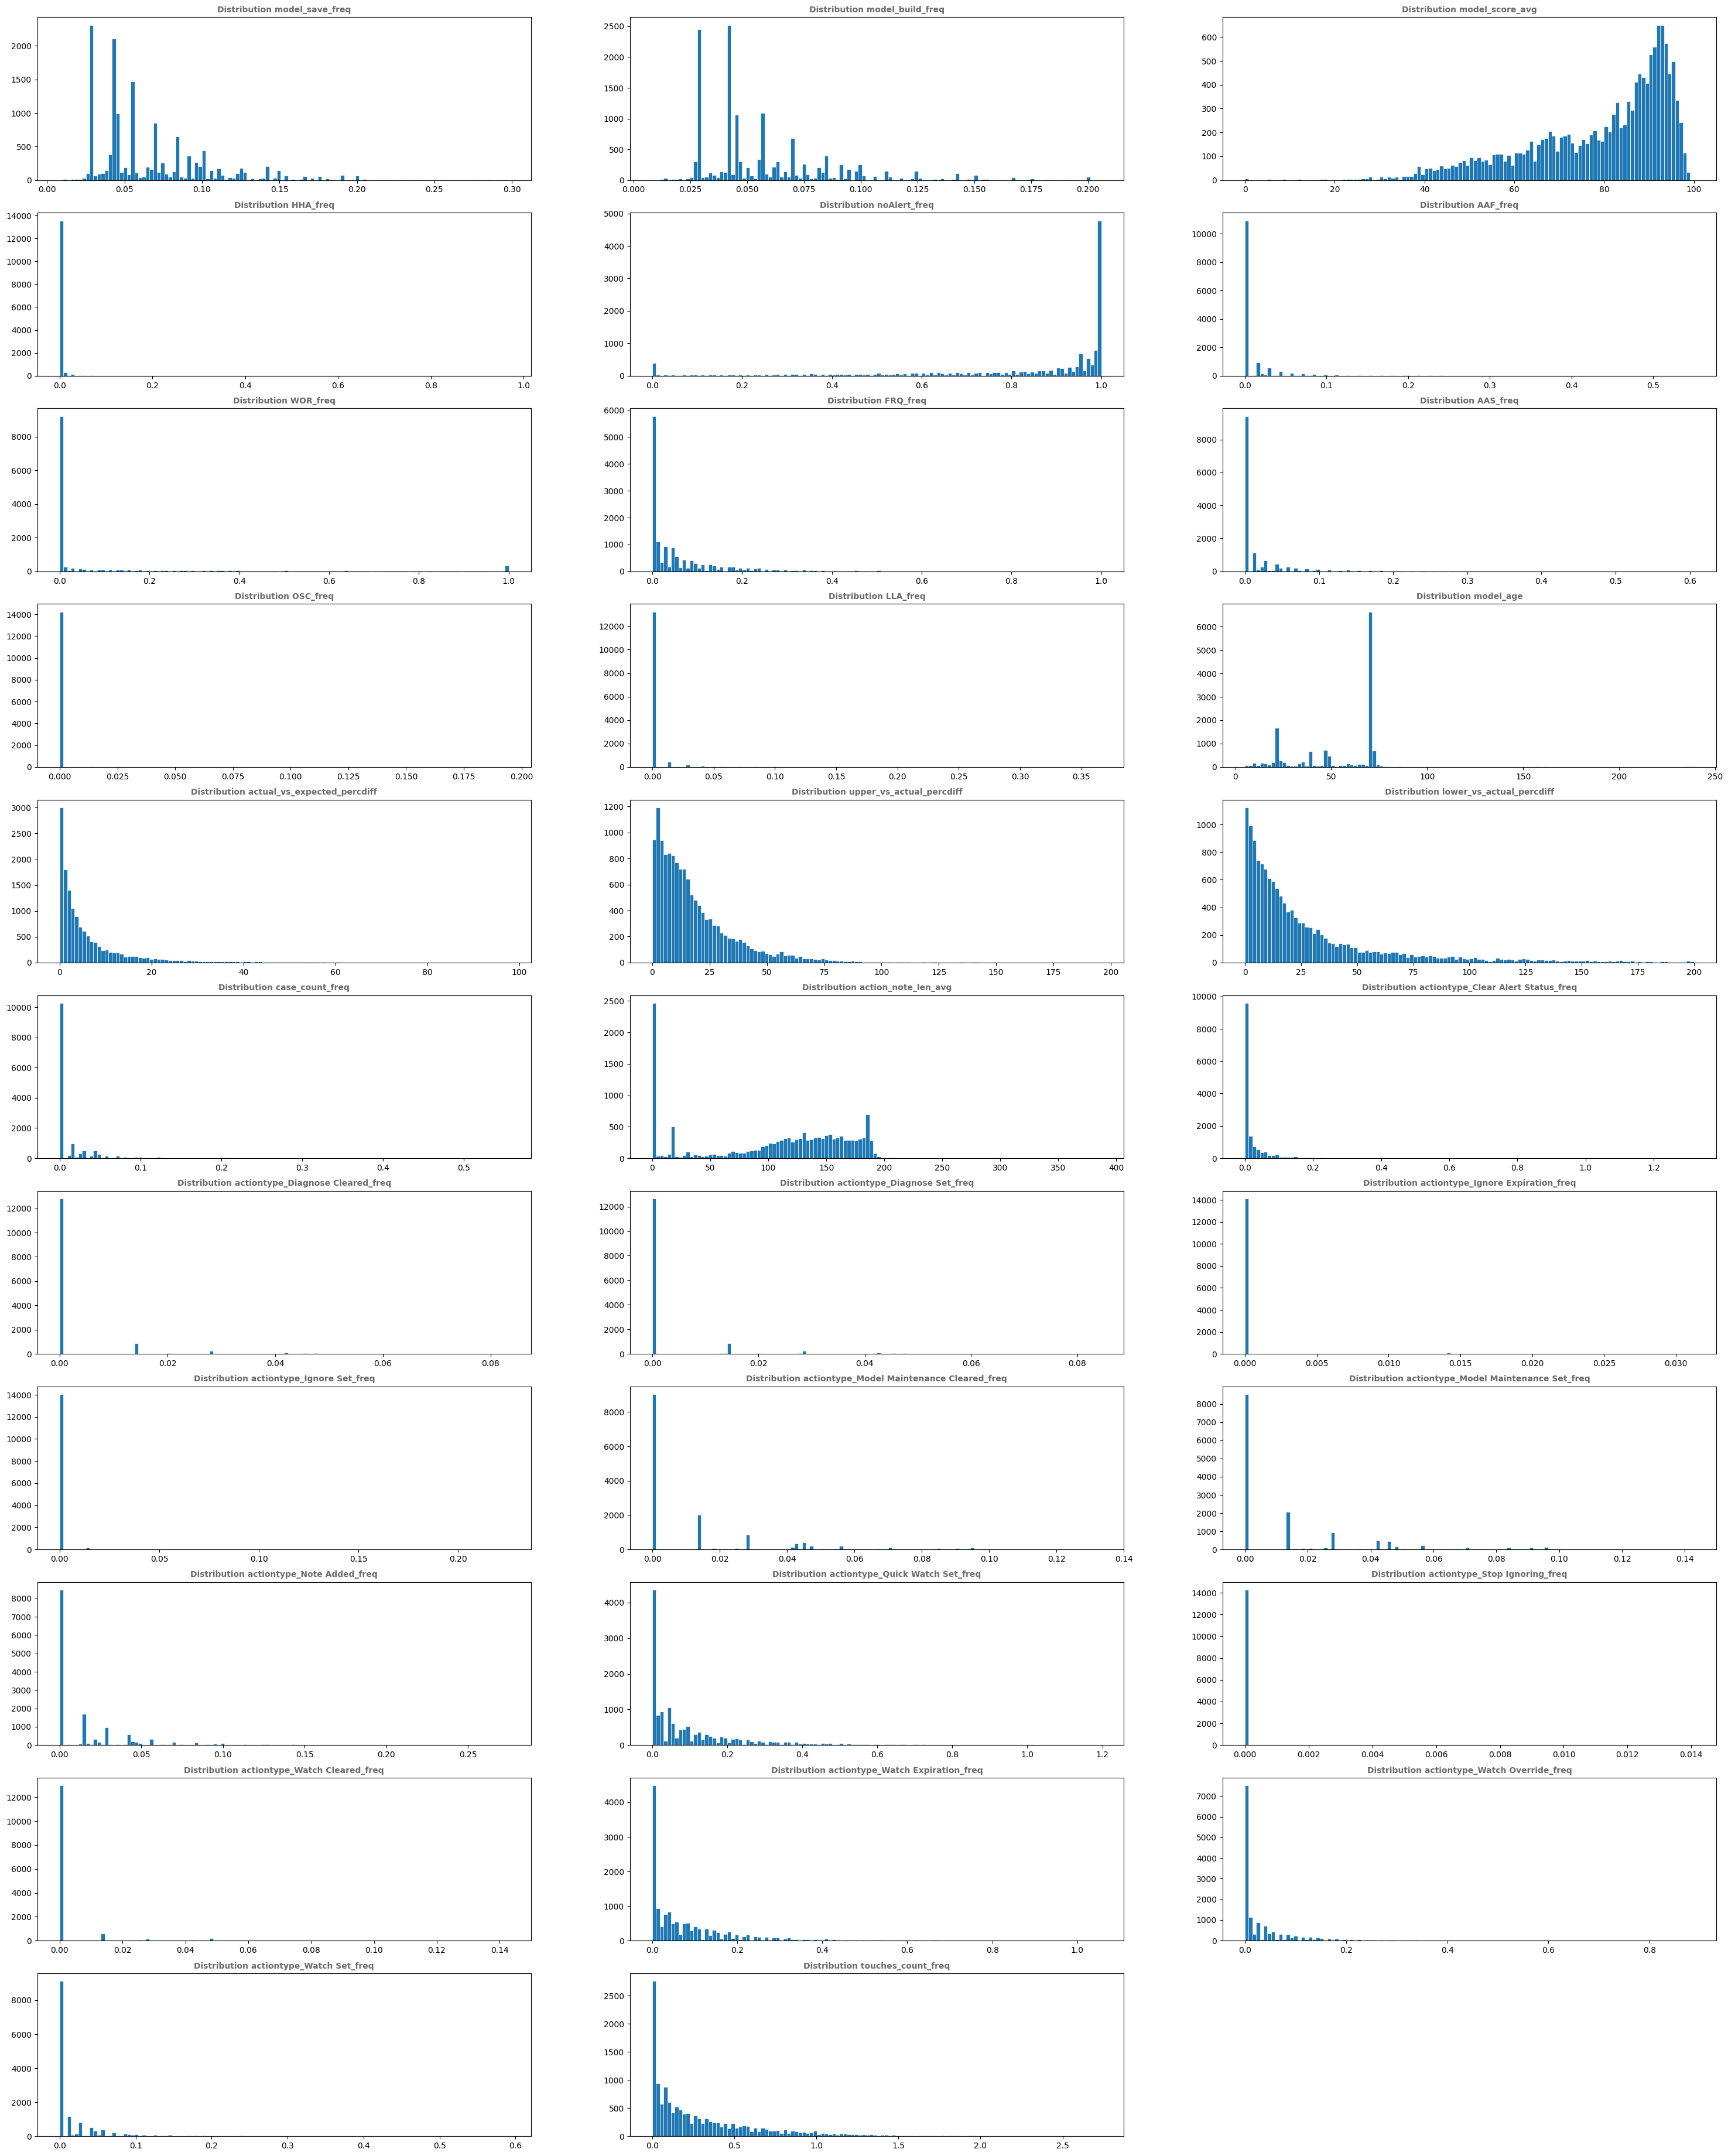

In [28]:
def StDev_method (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        
        # calculate the cutoff value
        cut_off = data_std * 3
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column = df[(df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_indices.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > data_mean + cut_off]
    df2 = df[df[column] < data_mean - cut_off]
    print('Total number of outliers is:', df1.shape[0]+ df2.shape[0])
    
    return multiple_outliers   

# # detecting outliers
# Outliers_StDev_cc = StDev_method(cc_df,1,cc_df_features)
# # dropping outliers
# cc_df_std = cc_df.drop(Outliers_StDev_cc, axis = 0).reset_index(drop=True)


# detecting outliers
Outliers_StDev_mq = StDev_method(df,1,mq_df_features)
# dropping outliers
mq_df_std = df.drop(Outliers_StDev_mq, axis = 0).reset_index(drop=True)
# detecting outliers


# plt_histo(cc_df_std[cc_df_features])
plt_histo(mq_df_std[mq_df_features])

Total number of outliers is: 205


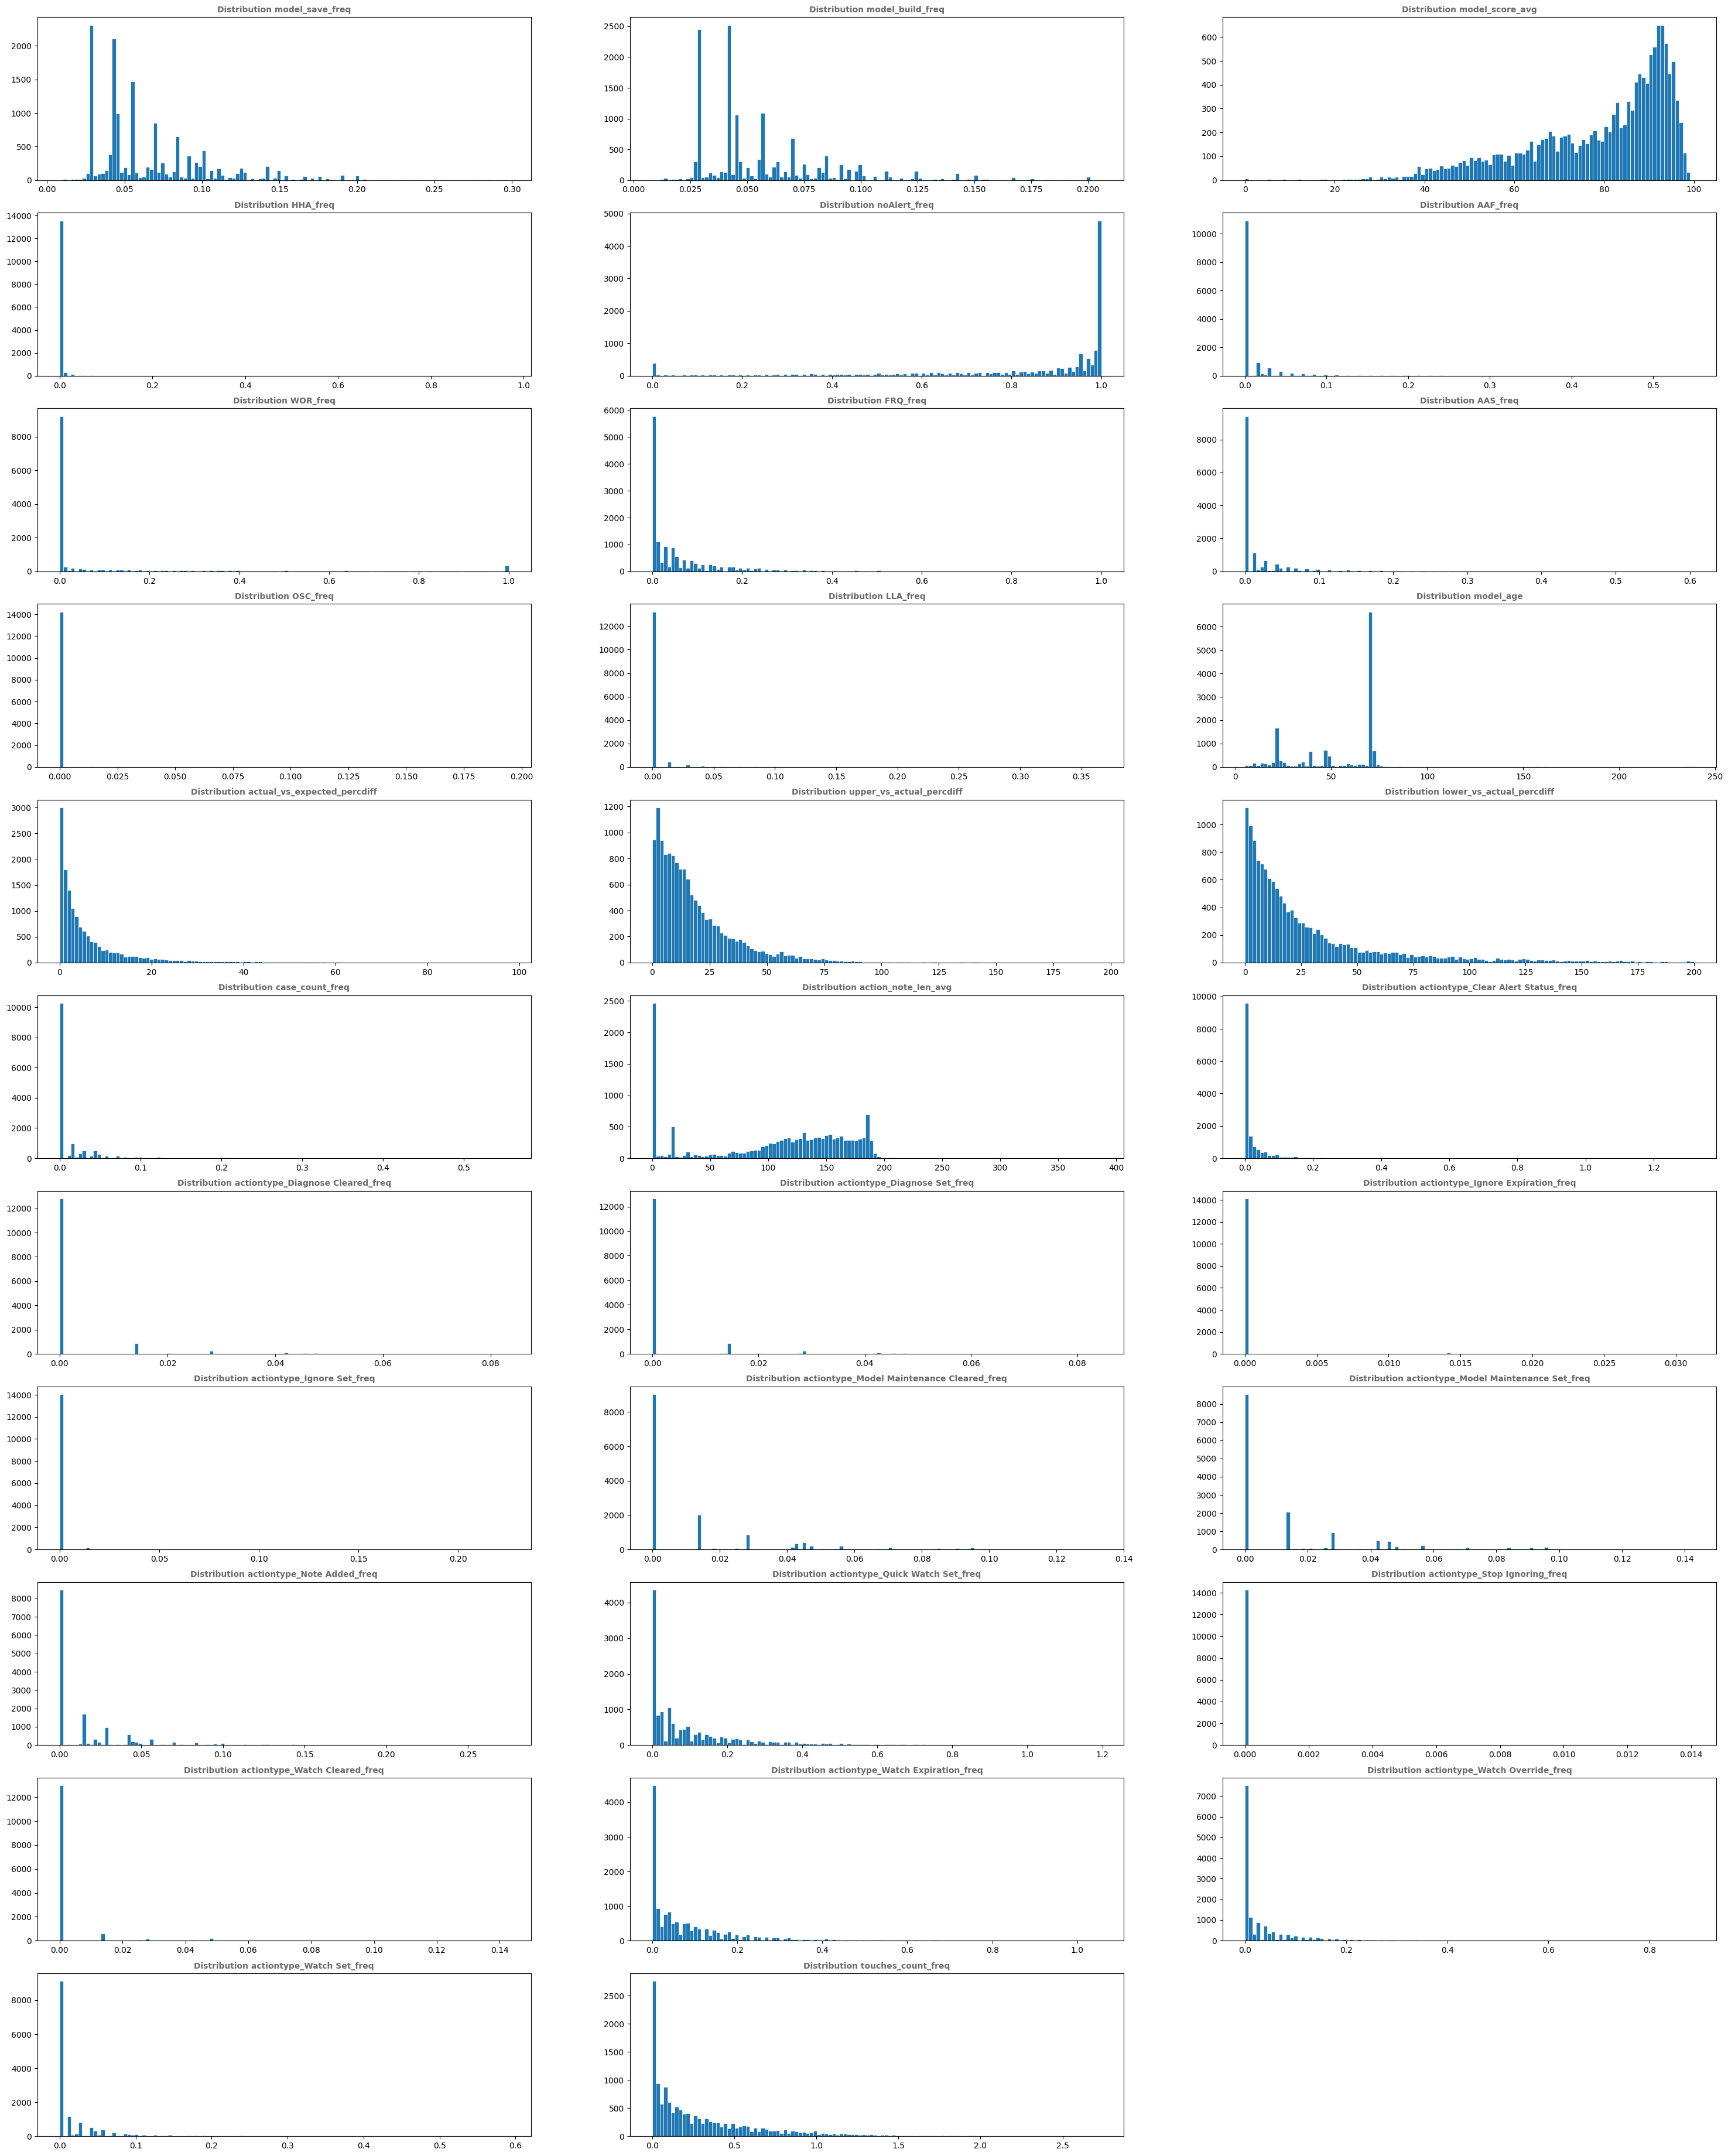

In [29]:
def z_score_method (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        
        z_score = abs( (df[column] - data_mean)/data_std )
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[z_score > threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[z_score > threshold]
    print('Total number of outliers is:', df1.shape[0])
    
    return multiple_outliers



# # detecting outliers
# Outliers_zscore_cc = z_score_method(cc_df,1,cc_df_features)
# # dropping outliers
# cc_df_zscore = cc_df.drop(Outliers_zscore_cc, axis = 0).reset_index(drop=True)


# detecting outliers
Outliers_zscore_mq = z_score_method(df,1,mq_df_features)
# dropping outliers
mq_df_zscore = df.drop(Outliers_zscore_mq, axis = 0).reset_index(drop=True)
# detecting outliers


# plt_histo(cc_df_zscore[cc_df_features])
plt_histo(mq_df_zscore[mq_df_features])

Total number of outliers is: 1591


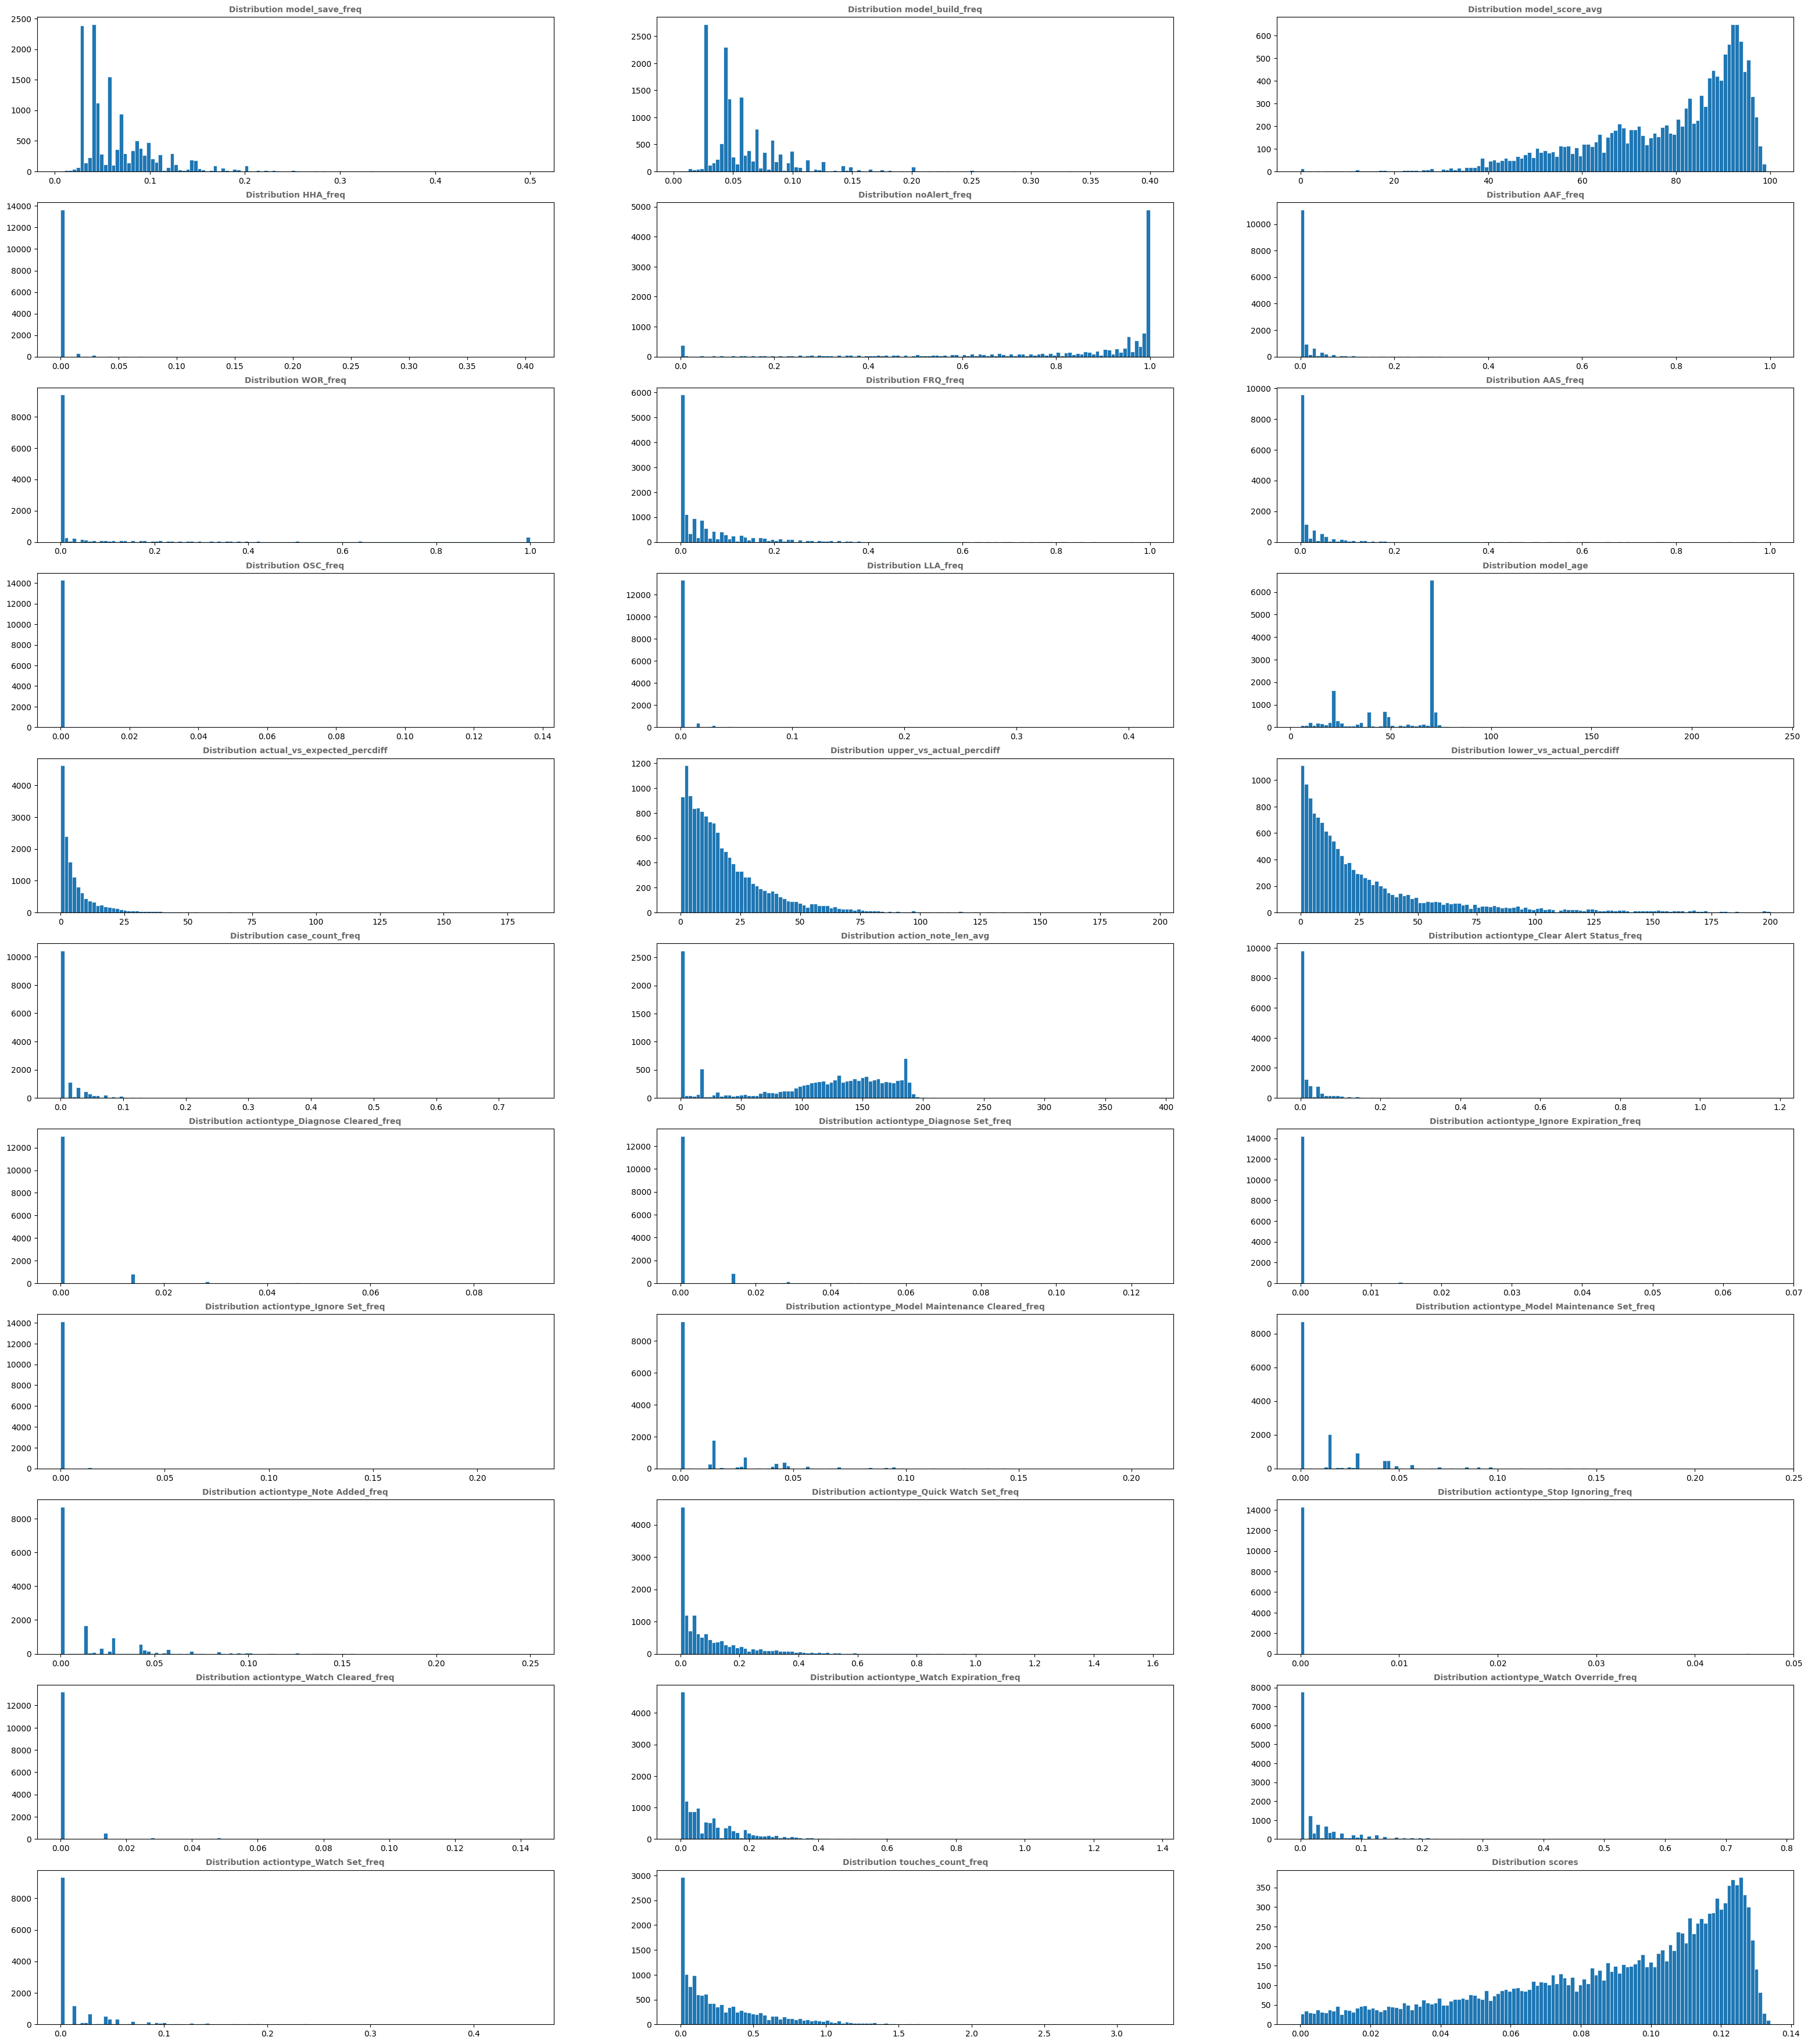

In [49]:


# df5 = cc_df[cc_df_features].copy()
df5 = df[mq_df_features].copy()

model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.1), max_features=1.0)
model.fit(df5)

IsolationForest(contamination=0.1, n_estimators=150)

scores=model.decision_function(df5)
anomaly=model.predict(df5)

df5['scores']=scores
df5['anomaly']=anomaly

anomaly = df5.loc[df5['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

# df5[df5['anomaly']==-1].head(10)

# dropping outliers
df_out5 = df5.drop(anomaly_index, axis = 0).reset_index(drop=True)
plt_histo(df_out5)

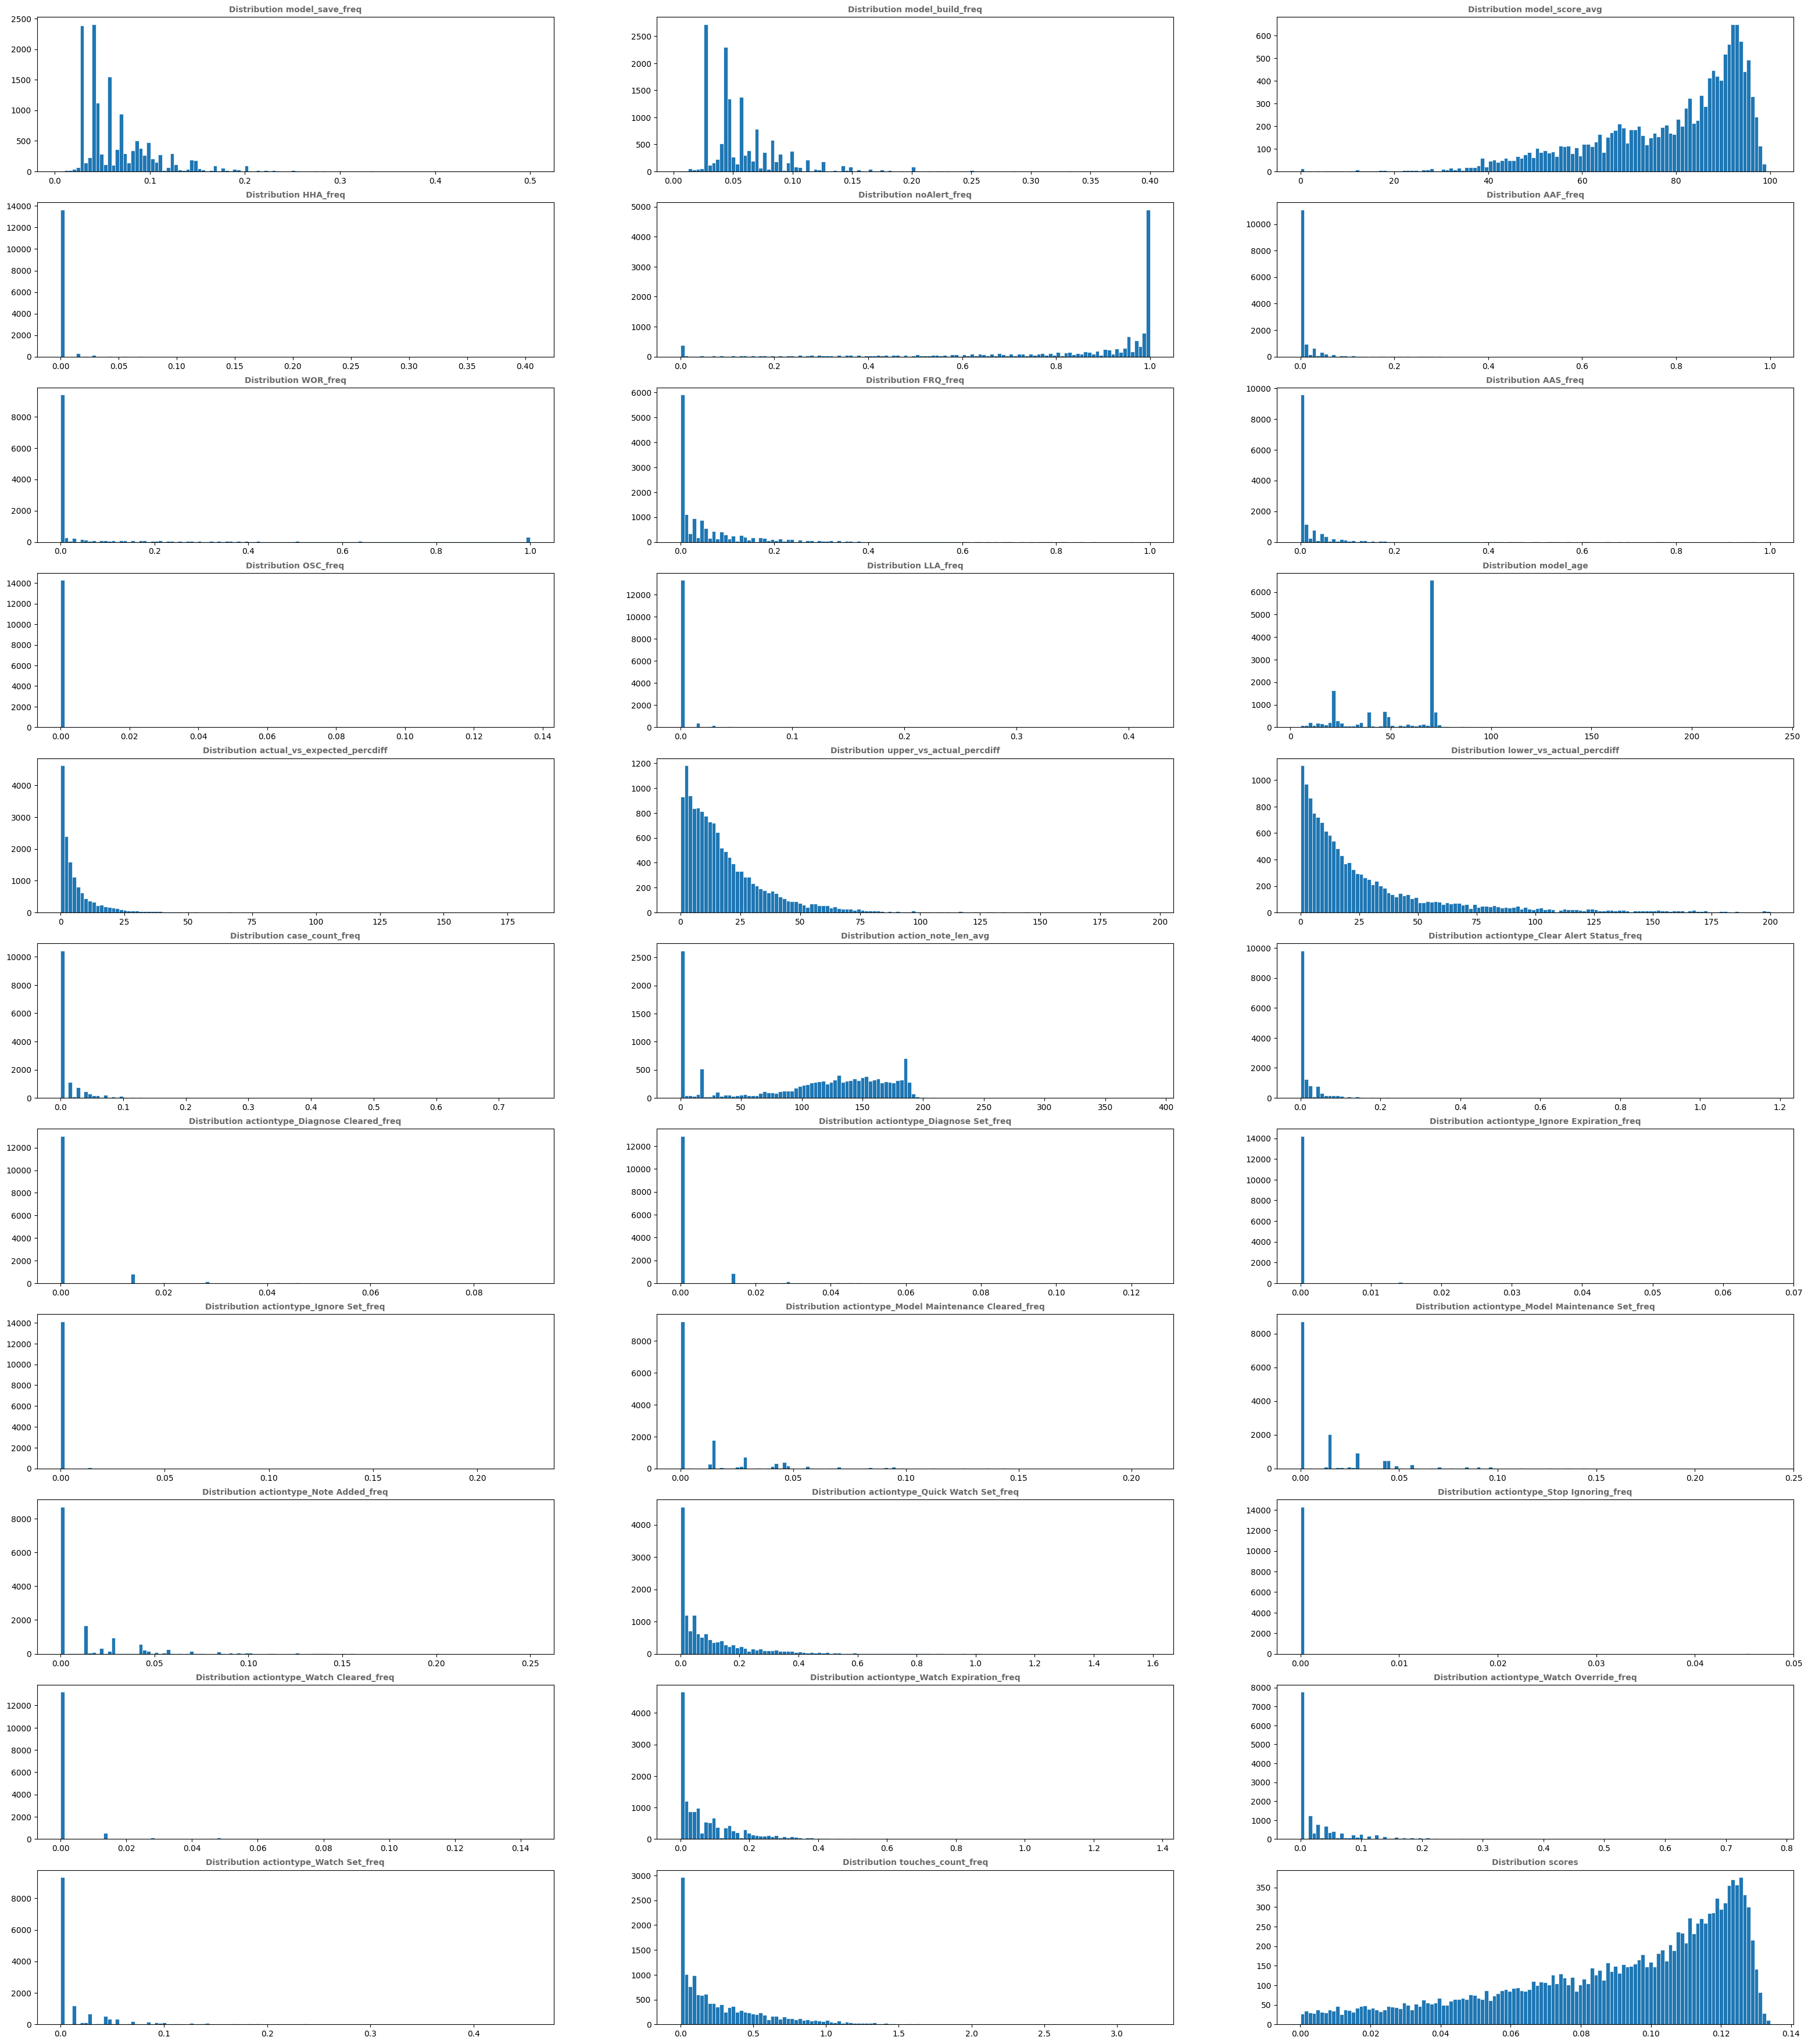

In [50]:
dfcpy = df_out5.copy()

columns_to_norm = [
    col for col in dfcpy.columns if len(dfcpy[col].value_counts()) != 2
]

dfcpy[columns_to_norm] = dfcpy[columns_to_norm].apply(lambda x: np.log(x + 1))




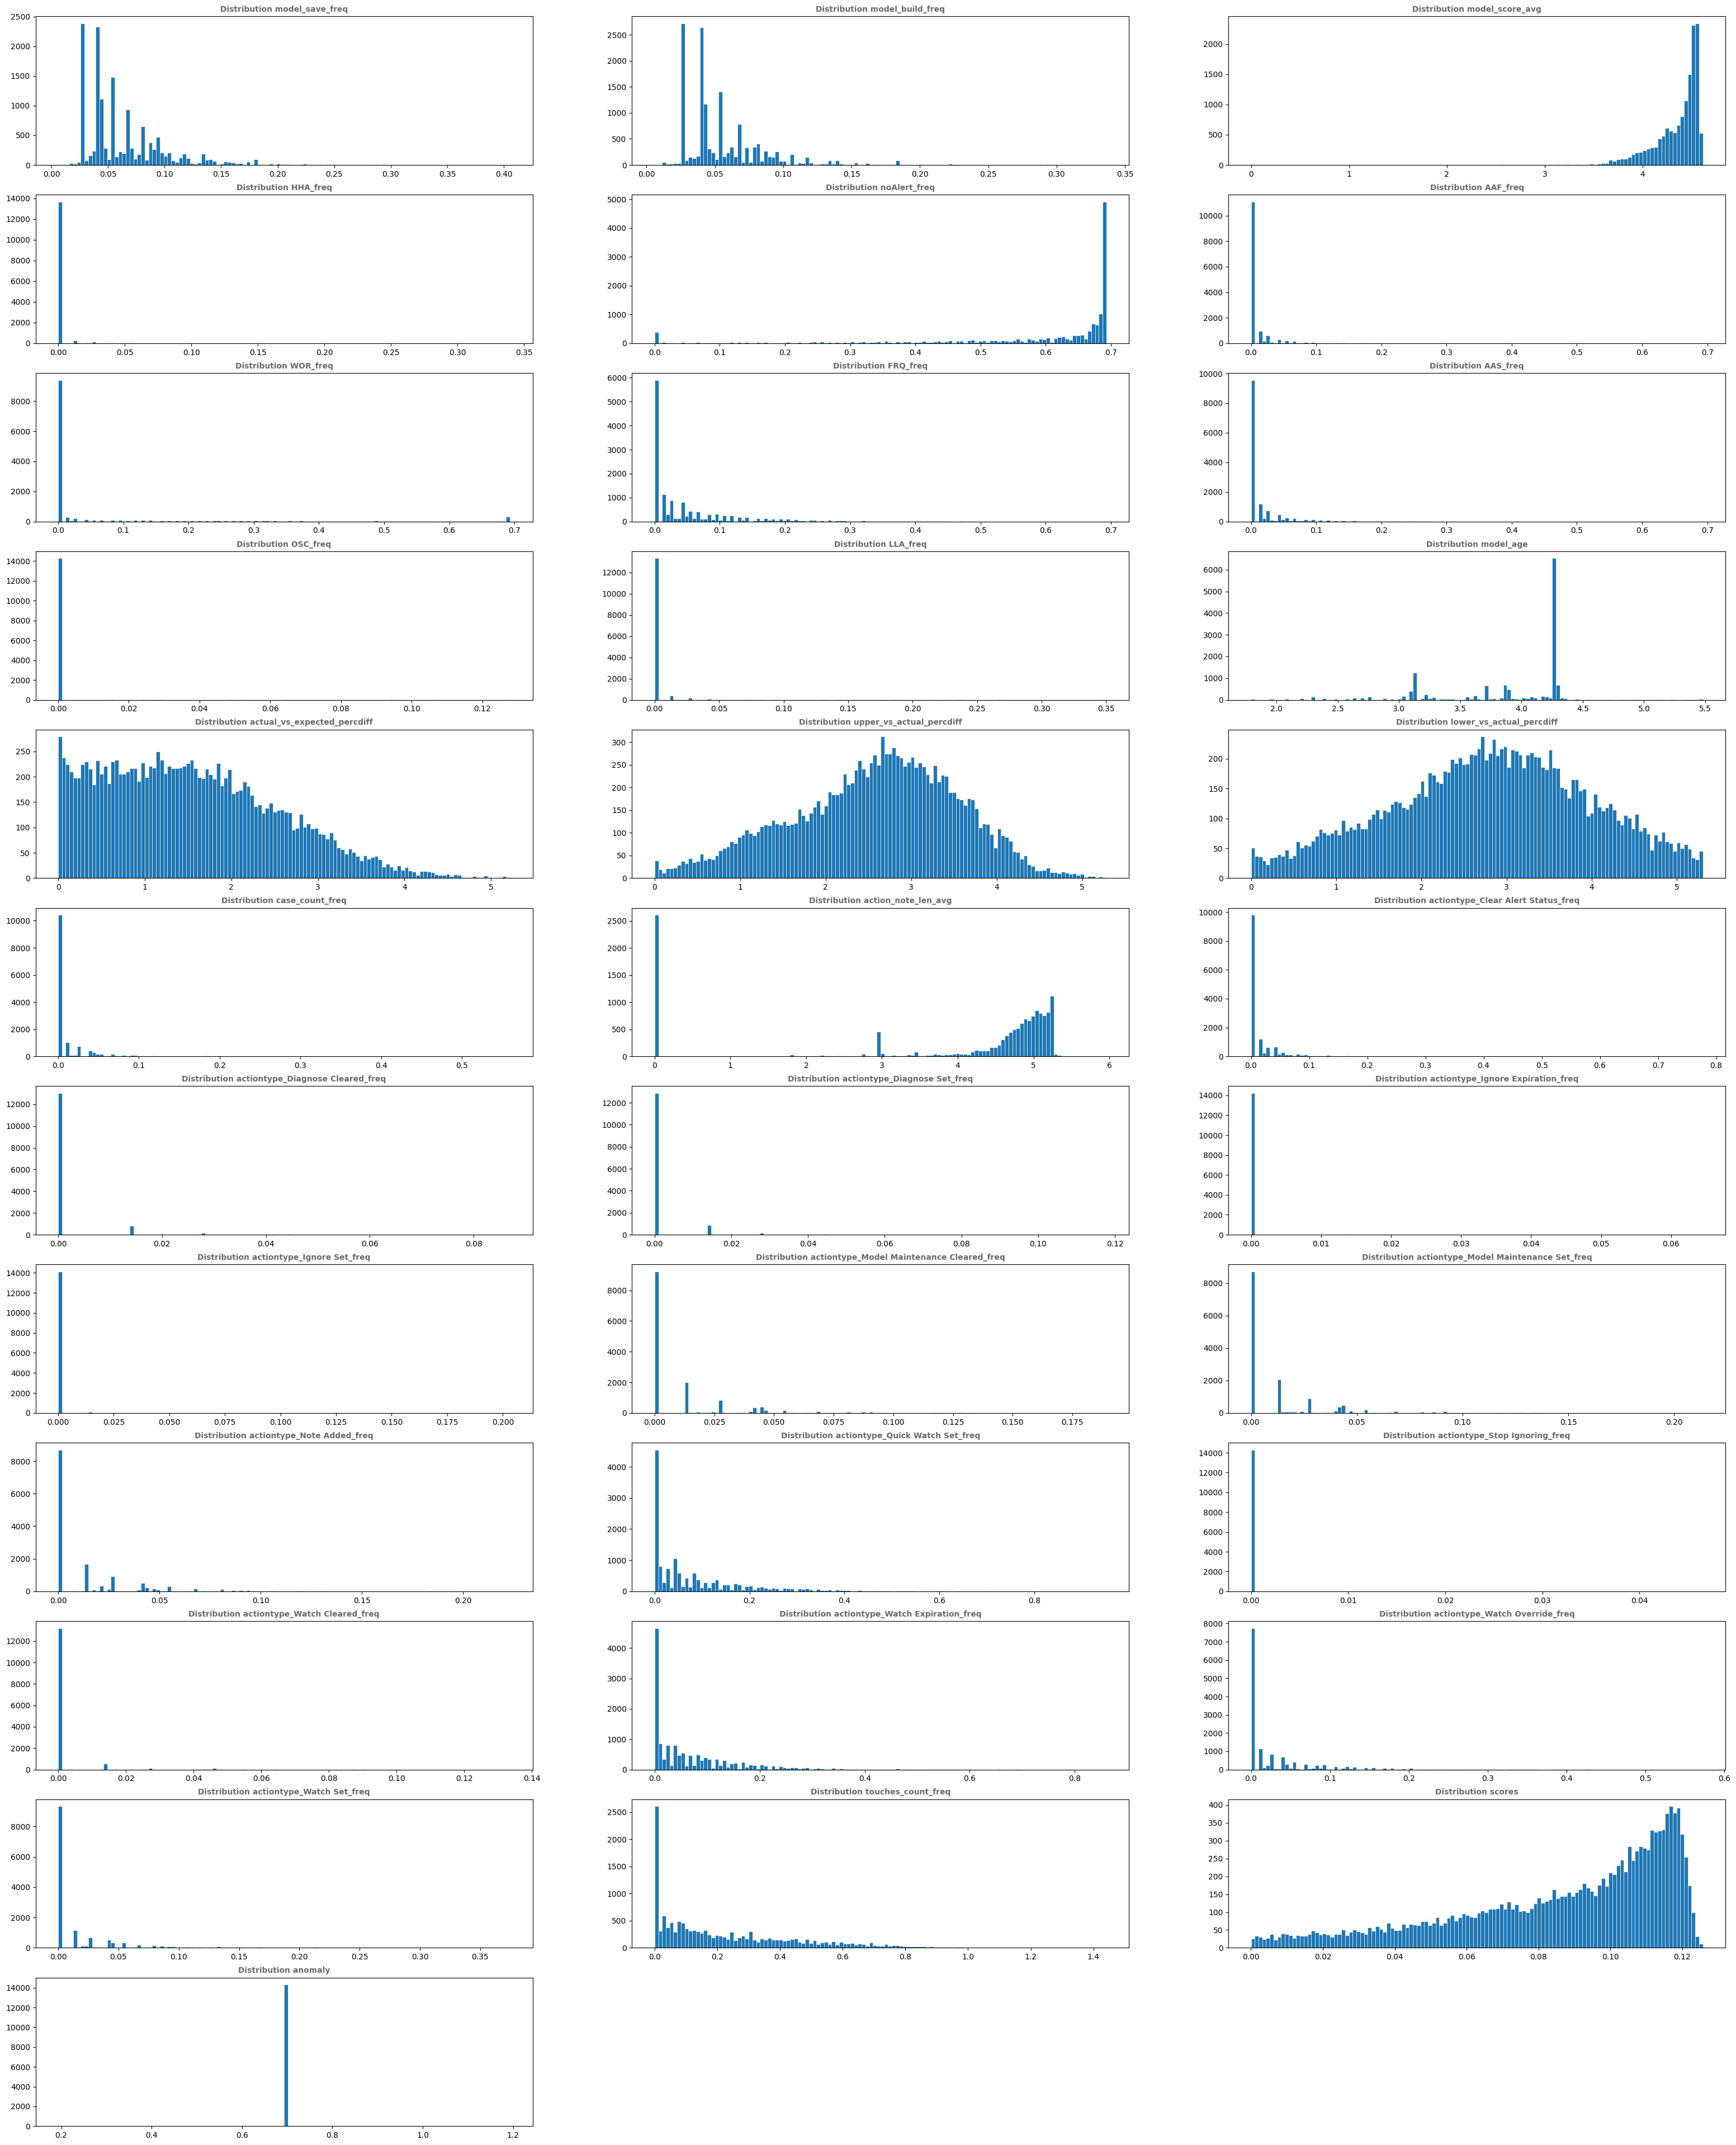

In [51]:
plt_histo(dfcpy)

In [ ]:


# normalize with Min-max
df_norm = df_out5[mq_df_features].copy()
# get only columns that are not 0 or 1 (ie have range of values)
columns_to_norm = [
    col for col in df_norm.columns if len(df_norm[col].value_counts()) != 2
]
min_max_scaler = preprocessing.MinMaxScaler()
df_norm[columns_to_norm] = min_max_scaler.fit_transform(df_norm[columns_to_norm])



# standardize with mean
df_stand = df_out5[mq_df_features].copy()
# get only columns that are not 0 or 1 (ie have range of values)
columns_to_stand = [
    col for col in df_stand.columns if len(df_stand[col].value_counts()) != 2
]
stand_scaler = preprocessing.StandardScaler()
df_stand[columns_to_stand] = stand_scaler.fit_transform(df_stand[columns_to_stand])


df_norm[columns_to_norm] = df_norm[columns_to_norm].apply(lambda x: np.log(x + 1))
df_stand[columns_to_stand] = df_stand[columns_to_stand].apply(lambda x: np.log(x + 1))

plt_histo(df_norm)
plt_histo(df_stand)

In [ ]:
def bootstrap_sample(amounts):
    return np.random.choice(amounts, len(amounts), replace=True)

def percentile_99(sample):
     return np.percentile(sample, 99)

def bootstrap_confidence_interval(data):
    """
    Creates list of 10000 99th percentile bootstrap replicates. 
    """
    bs_samples = np.empty(10000)
    
    for i in range(10000):
        bs_samples[i] = percentile_99(bootstrap_sample(data))

    return bs_samples

mq_df_boot = mq_df[mq_df_features].copy()
mq_df_boot_new = pd.DataFrame()

for col in mq_df_boot.columns.tolist():
    transactions_ci = bootstrap_confidence_interval(mq_df_boot[col])
    mq_df_boot_new[col] = transactions_ci


In [ ]:
plt_histo(mq_df_boot_new)

In [ ]:


# normalize with Min-max
df_norm = mq_df_boot_new[mq_df_features].copy()
# get only columns that are not 0 or 1 (ie have range of values)
columns_to_norm = [
    col for col in df_norm.columns if len(df_norm[col].value_counts()) != 2
]
min_max_scaler = preprocessing.MinMaxScaler()
df_norm[columns_to_norm] = min_max_scaler.fit_transform(df_norm[columns_to_norm])



# standardize with mean
df_stand = mq_df_boot_new[mq_df_features].copy()
# get only columns that are not 0 or 1 (ie have range of values)
columns_to_stand = [
    col for col in df_stand.columns if len(df_stand[col].value_counts()) != 2
]
stand_scaler = preprocessing.StandardScaler()
df_stand[columns_to_stand] = stand_scaler.fit_transform(df_stand[columns_to_stand])

plt_histo(df_norm)
plt_histo(df_stand)

In [ ]:
# def apply_kmeans(n_clust, data_to_fit, data_to_show):
#     # Apply the K-Means algorithm to 3 Clusters
#     kmeans = KMeans(n_clusters=n_clust, random_state=18)
#     kmeans.fit(data_to_fit)
#     df = data_to_show.copy()
#     df["cluster"] = kmeans.labels_

#     return df, kmeans

# cc = ClusterCentroids(random_state=0)

# kmeans = KMeans(n_clusters=3, random_state=18)
# kmeans.fit(mq_df[mq_df_features])

# def plot_general(df, xycol, plt_name='1'):
#     col_index_name = [(df.columns.get_loc(c), c) for c in df]
#     rows = (len(xycol) // 2) + 1
#     plt.figure(figsize=(20, 15))
#     plt.rcParams["xtick.labelsize"] = 8
#     plt.rcParams["ytick.labelsize"] = 8

#     for i in range(len(xycol)):
#         # i=0
#         x_col = col_index_name[xycol[i][0]]
#         y_col = col_index_name[xycol[i][1]]

#         plt.subplot(rows, 2, i + 1)
#         sns.scatterplot(data=df, x=x_col[1], y=y_col[1], hue="cluster", palette="Set2")
#         plt.title(
#             f"{x_col[1]} vs {y_col[1]}", fontsize=9, color="dimgrey", fontweight="bold"
#         )
#         plt.xlabel(x_col[1], color="dimgrey", labelpad=5, fontweight="bold", fontsize=7)
#         plt.ylabel(y_col[1], color="dimgrey", fontweight="bold", fontsize=7)

#     plt.subplots_adjust(wspace=0.4)
#     # plt.savefig(f"trials/v_{version}/scatter_images/{plt_name}.png")
#     plt.show()



#     X_resampled, y_resampled = cc.fit_resample(mq_df[mq_df_features], kmeans.labels_)
#     X_resampledcopy= X_resampled.copy()
# X_resampledcopy["cluster"] = y_resampled
# plot_general(X_resampledcopy, [(2,3)])
# plt_histo(mq_df[mq_df_features])

# # plt_histo(cc_df[cc_df_features])
# plt_histo(X_resampledcopy[mq_df_features])